# Homework 4 Programming Supplement
## Name 

This is the programming supplement to Homework 4.  Here, you will make synthetic Rayleigh wave seismograms.  In practice this is more complicated and we would typically use a normal mode summation or compute the response in a layer-cake model but the salient ideas are here.

In [1]:
from numpy import pi
from numpy import ones
from numpy import zeros
from numpy import asarray
from numpy import cos
from numpy import sin
from numpy import amax
from numpy import linspace
from matplotlib import pyplot as plt
from scipy.signal import hann
from scipy.signal import iirfilter, lfilter, filtfilt
%matplotlib inline  

In [2]:
# utility function
def deg2km(gcarc):
    """
    Converts great circle distance in degress to kilometers.
    
    Parameters
    ----------
    gcarc : float
         Great circle distance in degrees.
         
    Returns
    -------
    distkm : float
         The corresponding great circle distance in kilometers.
    """
    distkm = 111.195*gcarc
    return distkm

# Shearer Section 8.7 Question 4a

Here we assume that the Rayleigh wave phase velocity at periods between $50$ seconds to $500$ seconds can be approximated by the polynomial

\begin{equation}
   c(T) = 4.020 - 1.839 \times 10^{-3} T + 3.071 \times 10^{-5} T^2 - 3.549 \times 10^{-8} T^3
\end{equation}
where $T$ is the period in seconds and $c$ has units of km/s.

The group velocity, in km/s, was shown in the homework to be 
\begin{equation}
   U = \frac{c}{1 + \frac{T}{c} \frac{dc}{dT} }
\end{equation}

where the derivative is given by 
\begin{equation}
   \frac{dc}{dT} 
  =-1.839 \times 10^{-3} + 2 \times 3.071 \times 10^{-5} T - 3 \times 3.549 \times 10^{-8} T^2
\end{equation}

Given this, fill in the following code segments

In [3]:
def compute_C(T):
    """
    Computes the phase velocity as a function of period.
    
    Parameters
    ----------
    T : array_like
        The period in seconds at which to compute the phase velocities.
         
    Returns
    -------
    c : array_like
        The corresponding phase velocities in km/s.
    """
    c = 4.02 - 1.839e-3*T + 3.071e-5*T**2 - 3.549e-8*T**3 
    return c

def compute_dcdT(T):
    """
    Computes the derivative of the phase velocity with respect to the period. 
    
    Parameters
    ----------
    T : array_like
        The period in seconds at which to compute dc/dT
         
    Returns
    -------
    dcdT : array_like
        The corresponding derivatives of the phase velocity in km/s/s.
    """    
    dcdT = #Put your code here 
    return dcdT

def compute_U(T):
    """
    Computes the group velocity for the given period.
    
    Parameters
    ----------
    T : array_like
        The period in seconds at which to compute the group velocity.
         
    Returns
    -------
    U : array_like
        The corresponding group velocity in km/s.
    """    
    c = # Compute phase velocity 
    dcdT = # Compute derivative of phase velocity 
    U = # Compute group velocity 
    return U

def unit_test():
    assert( abs(compute_C(250) - 4.92509) < 1.e-2), "Phase velocity is wrong"
    assert( abs(compute_U(250) - 3.65281) < 1.e-2), "Group velocity is wrong"
    return True

lpass = unit_test()
if (lpass):
    print("Passed unit test")
else:
    print("Failed unit tests")



Passed unit test


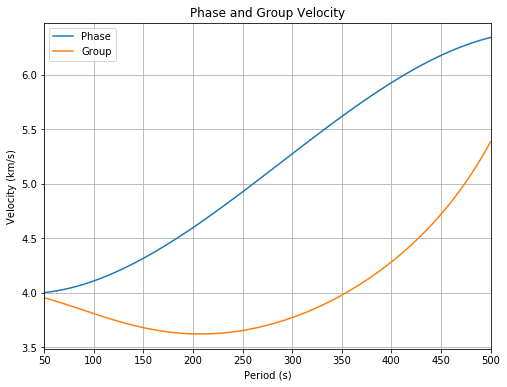

In [4]:
# Plot the result
T = linspace(50,500,451)
c = compute_C(T) # Phase velocity
U = compute_U(T) # Group velocity
plt.figure(figsize=(8,6))
plt.plot(T, c, label='Phase')
plt.plot(T, U, label='Group')
plt.ylabel('Velocity (km/s)')
plt.xlabel('Period (s)')
plt.title("Phase and Group Velocity")
plt.xlim(50,500)
plt.grid(True)
plt.legend()
plt.show()

# Question: Is the phase or group velocity faster?
    
PUT YOUR ANSWER HERE

# Simplified Surface Wave Synthetics 

In class we derived a form for Rayleigh waves at the free surface

\begin{equation}
  u_x(t, x, z=0) = 0.42 A k_x \sin (\omega t - k_x x_1)
\end{equation}

\begin{equation}
  u_z(t, x, z=0) = 0.62 A k_x \cos (\omega t - k_x x_1)
\end{equation}

where a Poisson solid was assumed.  Here, we'll set the amplitude to $1$.  Additionally, in our derivation we assumed that the medium was a halfspace.  Here, we will allow the wavenumber to vary with frequency.  In practice Rayleigh waves are disperisive so this is an appropriate thing to do.  The phase velocities were previously defined.

Of course, each solution is monochromatic.  Hence, we have to compute the superposition of all frequencies, i.e., 

\begin{equation}
  u_x(t, x, 0) = \sum_{\omega=\omega_0}^{\omega_1}  0.42 \frac{\omega}{c} \sin \left ( \omega t - \frac{\omega}{c} x_1 \right )
\end{equation}

\begin{equation}
  u_x(t, x, 0) = \sum_{\omega=\omega_0}^{\omega_1} 0.62 \frac{\omega}{c} \cos \left ( \omega t - \frac{\omega}{c} x_1 \right )
\end{equation}

where $\omega_0$ and $\omega_1$ are the angular cutoff frequencies.  It remains an open question what the frequency sampling should be.  From Fourier analysis one can show that the temporal duration is simply related to the frequency resolution is related the temporal sampling period by $ \Delta f = \frac{1}{N \Delta T}$ or 

\begin{equation}
  \Delta \omega = \frac{2 \pi }{N \Delta T}
\end{equation}

where $N$ is the number of samles and $\Delta T$ the sampling period.  The number of frequencies is then found with 

\begin{equation}
  N_\omega =\operatorname{int} \left \{ \frac{\omega_1 - \omega_0}{\Delta \omega} \right \} + 1
\end{equation}

## Implementation 1

Therefore, we can rewrite the summations as 

\begin{equation}
  u_x(t, x, 0) = 0.42 \sum_{j=0}^{N_\omega-1} \frac{(\omega_0 + j \Delta \omega)}{c}
                 \sin \left ((\omega_0 + k \Delta \omega) \cdot \left (t - \frac{1}{c(T)} x_1  \right )\right )
\end{equation}

\begin{equation}
  u_x(t, x, 0) = 0.62 \sum_{j=0}^{N_\omega-1} \frac{(\omega_0 + j \Delta \omega)}{c} 
                 \cos \left ((\omega_0 + k \Delta \omega) \cdot \left (t - \frac{1}{c(T)} x_1  \right )\right )
\end{equation}

where $c$ is the apparent velocity in $x$ which is a function of period, and by extension, angular frequency. 

## Implementation 2

Such an implementation can yield seismograms that ring.  This is because we are effectively applying a bandpass filter with sharp cutoff frequencies.  To mitigate this ringing we can apply a window function which tapers to $0$ at the cutoff frequencies.  To do this introduce a Hann window function defined by 

\begin{equation}
  W(\omega) = \sin^2 \left (\pi \frac{\omega - \omega_0}{\omega_2 - \omega_1} \right )
\end{equation}

Notice, that this is $0$ at $\omega = \omega_0$ and $\omega = \omega_1$.  It is therefore sufficient to use a discrete version 

\begin{equation}
  W_j = \frac{1}{2} - \frac{1}{2} \cos \left ( \frac{2\pi j}{N_f - 1} \right ); \, \qquad j=0,1, \cdots N_f - 1
\end{equation}

which is the Hann window defined in Scipy.  Thus, we have a second implementation

\begin{equation}
  u_x(t, x, 0) = 0.42 \sum_{j=0}^{N_\omega-1} \frac{(\omega_0 + j \Delta \omega)}{c}
                 \sin \left ((\omega_0 + k \Delta \omega) \cdot \left (t - \frac{1}{c(T)} x_1  \right )\right ) W_j
\end{equation}

\begin{equation}
  u_x(t, x, 0) = 0.62 \sum_{j=0}^{N_\omega-1} \frac{(\omega_0 + j \Delta \omega)}{c} 
                 \cos \left ((\omega_0 + k \Delta \omega) \cdot \left (t - \frac{1}{c(T)} x_1  \right )\right ) W_j
\end{equation}

## Your Turn:

Implement a function that computes Rayleigh wave synthetics on both the vertical and radial channels given the phase velocity curve defined in the previous problem.

In [5]:
def rayleigh(gcarc=asarray([0, 30, 90, 150]), Tmax=1.5*3600, dt=5, 
             f0=0.002, f1=0.02, df=None, useWindow=True):
    """
    Computes the radial and vertical Rayleigh waves at the free surface.  Here, the
    phase velocity is modeled by compute_C which assumes:
    c(T) = 4.020 - 1.839 \times 10^{-3} T + 3.071 \times 10^{-5} T^2 - 3.549 \times 10^{-8} T^3

    Parameters
    ----------
    gcarc : array_like
        The receiver distances in degrees at which the seismograms 
        are to be computed.  This has dimension equal to the number of receivers.
    Tmax : float
        The max modeling time in seconds.
    dt : float
        The sampling period of the time domain seismograms in seconds.
    f0 : float
        The low cutoff frequency in Hz.
    f1 : float
        The high cutoff frequency in Hz.
    df : float
        The desired sampling frequency in Hz.  If not specified the default will be
        analytically computed.  Choosing a small sampling frequency can mitigate 
        wraparound.
    useWindow : bool
        If True then use a Hann window function to reduce ringing in time domain.
        
    Returns
    -------
    times : array_like
        An array of times in seconds at which the synthetics are defined.  This
        has dimension [nt] where nt is the number of time samples.
    gatherr : matrix
        A matrix of radial channel seismograms tabulated at distances specified with
        gcarc with dimension [nrec x nt] where nrec is the number of receivers 
        and nt is the number of time samples.
    gatherv : matrix
        A matrix of vertical channel seismograms tabulated at distances specified with
        gcarc with dimension [nrec x nt] where nrec is the number of receivers 
        and nt is the number of time samples.
    """
    # Warn on aliasing
    if (f1 > 1./(2.0*dt)):
        print("Warning - signal will be aliased")
    # Initialize parameters for modeling
    nrec = len(gcarc)                      # Number of receivers
    x = deg2km(gcarc)                      # Convert the great circle distances to degrees    
    nt = int((Tmax - 0)/dt) + 1            # Compute the number of samples in the seismogram
    times = linspace(0, Tmax, nt)          # Compute the times at which to tabulate the response
    omega0 =                               # Compute the lowcut angular frequency
    omega1 =                               # Compute the highcut angular frequency
    # If df is not given then estimate it
    if (df is None):
        domega = 2.0*pi/(nt*dt) 
    else:
        domega = 2.0*pi*df                 # Convert to angular frequency
    nf = int((omega1 - omega0)/domega) + 1 # Number of modeling frequencies
    omega =                            )   # Compute the modeling frequencies with linspace
    # Precompute the phase velocities and wavenumbers
    T =                                    # Compute the periods at which to evaluate c(T)
    c =                                    # Compute the phase velocities for each frequency with compute_C(T)
    k =                                    # Compute wavenumber in x from omega and c
    p =                                    # Compute the apparent slowness in x from c
    # Handle window function
    if (useWindow):
        w = hann(len(omega))               # Have SciPy calculate the Hann window
    else:
        w = ones(len(omega))               # Dirty trick to write same code for Implementaiton 1 and 2
    # Set space for the gather
    gatherr = zeros([nrec, nt])
    gatherz = zeros([nrec, nt])
    # Model each seismogram
    for irec in range(nrec):
        seisr = zeros(nt) # Allocate space to radial resonse
        seisz = zeros(nt) # Allocate space to vertical response
        # Loop on each temporal index
        for it in range(nt):
            seisr[it] =   # Compute radial synthetic at time[it]
            seisz[it] =   # Compute vertical synthetic at time [it]
        gatherr[irec,:] = seisr[:] # Copy radial repsonse to gather
        gatherz[irec,:] = seisz[:] # Copy vertical response to gather
    # End loop on receivers
    return times, gatherr, gatherz


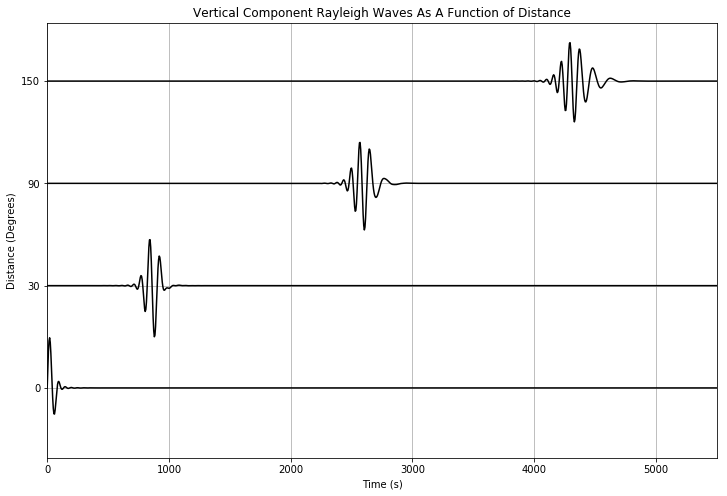

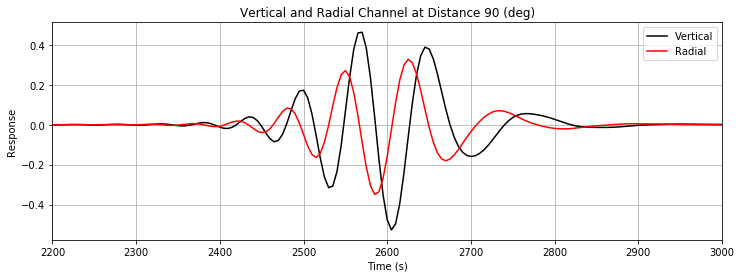

In [6]:
# Compute the rayleigh wave response on the vertical component
gcarc = asarray([0, 30, 90, 150])
times, gatherr, gatherz = rayleigh(Tmax=6500, useWindow=True)
nrec = gatherr.shape[0]
# Plot the gather
maxresp = max(amax(abs(gatherr)), amax(abs(gatherz)))
yticks = []
ylabels = []
plt.figure(figsize=(12,8))
for irec in range(nrec):
    yshift = irec*(2*maxresp)
    plt.plot(times, gatherz[irec,:] + yshift, color='black')    
    #plt.plot(times, gatherr[irec,:] + yshift, color='red',   linewidth=1)
    yticks.append(yshift)
    ylabels.append("%s"%str(gcarc[irec]))
plt.yticks(yticks, ylabels)
plt.xlabel("Time (s)")
plt.ylabel("Distance (Degrees)")
plt.title("Vertical Component Rayleigh Waves As A Function of Distance")
plt.xlim(0, min(5500, max(times)))
plt.grid(True)
plt.show()


plt.figure(figsize=(12,4))
plt.plot(times, gatherz[2,:], color='black', label='Vertical')
plt.plot(times, gatherr[2,:], color='red',   label='Radial')
plt.xlim(2200, 3000)
plt.legend()
plt.grid(True)
plt.ylabel("Response")
plt.xlabel("Time (s)")
plt.title("Vertical and Radial Channel at Distance %.0f (deg)"%(gcarc[2]))
plt.show()

# Question: Is this Rayleigh wave dispersive?

PUT YOUR ANSWER HERE 

Now we put the synthetics through a series of narrow band filters to estimate the Rayleigh wave onset time.  This is how the group velocity could be computed in practice.  

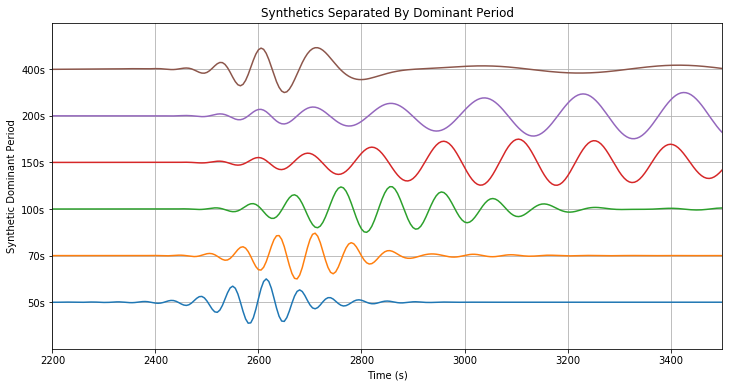

In [7]:
# Next lets pass this through some narrow band filters
resp = zeros(len(times))
resp[:] = gatherz[2,:]

# Compute nyquist
fnyq = 1.0/(2*(times[1] - times[0]))
# Filter design  IIR bandpass filters
W = [1./60., 1./40]/fnyq
b50,  a50  = iirfilter(N=2, Wn=W, btype='band', output='ba')
W = [1./80., 1./60]/fnyq
b70,  a70  = iirfilter(N=2, Wn=W, btype='band', output='ba')
W = [1./110, 1./90]/fnyq
b100, a100 = iirfilter(N=2, Wn=W, btype='band', output='ba')
W = [1./160, 1./140]/fnyq
b150, a150 = iirfilter(N=2, Wn=W, btype='band', output='ba')
W = [1./210, 1./190]/fnyq
b200, a200 = iirfilter(N=2, Wn=W, btype='band', output='ba')
W = [1./410, 1./390]/fnyq
b400, a400 = iirfilter(N=2, Wn=W, btype='band', output='ba')

# Apply the filters
resp50  = lfilter(b50,  a50,  resp)
resp70  = lfilter(b70,  a70,  resp)
resp100 = lfilter(b100, a100, resp)
resp150 = lfilter(b150, a150, resp)
resp200 = lfilter(b200, a200, resp)
resp400 = lfilter(b400, a400, resp)

# Rescale so everyone is the same size
resp50  = resp50/max(abs(resp50))
resp70  = resp70/max(abs(resp70))
resp100 = resp100/max(abs(resp100))
resp150 = resp150/max(abs(resp150))
resp200 = resp200/max(abs(resp200))
resp400 = resp400/max(abs(resp400))

# Plot
plt.figure(figsize=(12,6))
plt.ylim(-2, 12)
plt.yticks([0, 2, 4, 6, 8, 10], ["50s", "70s", "100s", "150s", "200s", "400s"])
plt.plot(times, resp50,    label='50s')
plt.plot(times, resp70 +2,    label='70s')
plt.plot(times, resp100+4, label='100s')
plt.plot(times, resp150+6, label='150s')
plt.plot(times, resp200+8, label='200s')
plt.plot(times, resp400+10,label='400s')
plt.grid(True)
plt.xlim(2200, 3500)
plt.xlabel("Time (s)")
plt.ylabel("Synthetic Dominant Period")
plt.title("Synthetics Separated By Dominant Period")
plt.show()

# Question: Based on your plot of phase velocity and group velocity, are  seismograms better representations of group velocity or phase velocity?

PUT YOUR ANSWER HERE